In [2]:
import pandas as pd
import numpy as np
import warnings
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

## Data Load

- 서울시 인구 데이터: [출처](https://data.seoul.go.kr/dataList/419/S/2/datasetView.do)
- 서울시 연령대별 인구 데이터: [출처](https://data.seoul.go.kr/dataList/10837/S/2/datasetView.do)
- 서울시 범죄 발생현황 데이터: [출처](https://data.seoul.go.kr/dataList/316/S/2/datasetView.do)
- 서울시 월평균 소득 데이터: [출처](https://data.seoul.go.kr/dataList/OA-22167/S/1/datasetView.do#AXexec) 
- 서울시 공원 데이터: [출처](https://data.seoul.go.kr/dataList/OA-394/S/1/datasetView.do)
- 서울시 주택가격지수 데이터: [출처](https://data.seoul.go.kr/dataList/801/S/2/datasetView.do)
- 서울시 지가변동률 데이터: [출처](https://data.seoul.go.kr/dataList/10401/S/2/datasetView.do)
- 금리 데이터: [출처](https://kosis.kr/statHtml/statHtml.do?sso=ok&returnurl=https%3A%2F%2Fkosis.kr%3A443%2FstatHtml%2FstatHtml.do%3Fconn_path%3DMT_ZTITLE%26list_id%3DS1_301006_004_001_002%26obj_var_id%3D%26seqNo%3D%26tblId%3DDT_121Y006%26vw_cd%3DMT_ZTITLE%26itm_id%3D%26language%3Dkor%26lang_mode%3Dko%26orgId%3D301%26)
- 기대 인플레이션 데이터: [출처](https://kosis.kr/statHtml/statHtml.do?sso=ok&returnurl=https%3A%2F%2Fkosis.kr%3A443%2FstatHtml%2FstatHtml.do%3Fconn_path%3DMT_ZTITLE%26list_id%3DJ1_301020%26obj_var_id%3D%26seqNo%3D%26tblId%3DDT_511Y003%26vw_cd%3DMT_ZTITLE%26itm_id%3D%26language%3Dkor%26lang_mode%3Dko%26orgId%3D301%26)

In [3]:
population = pd.read_csv("../data/Original_data/2023-등록인구.csv", header=1, index_col=0)
age_pop =pd.read_csv("../data/Original_data/자치구별+연령별+인구.csv", header=1, index_col=0)
crime = pd.read_csv("../data/Original_data/2023-5대-범죄-발생현황.csv", header=1, index_col=0)
garden = pd.read_csv("../data/Original_data/서울시 주요 공원현황.csv", encoding='euc-kr')
money = pd.read_csv("../data/Original_data/서울시 상권분석서비스(소득소비-자치구).csv", encoding='euc-kr')
house_price = pd.read_csv("../data/Original_data/주택가격지수(매매).csv")
land_price = pd.read_csv("../data/Original_data/지가변동률.csv", encoding='UTF-8')
interest_rate = pd.read_csv("../data/Original_data/예금은행_대출금리.csv", encoding='UTF-8')
inflation = pd.read_csv("../data/Original_data/기대인플레이션율.csv", encoding='euc-kr')

print(f"서울시 인구 데이터: {population.shape}")
print(f"서울시 나이대별 인구 데이터: {age_pop.shape}")
print(f"서울시 범죄 데이터: {crime.shape}")
print(f"서울시 공원 데이터: {garden.shape}")
print(f"전국 시군구 평균소득: {money.shape}")
print(f"서울시 자치구별 주택가격지수: {house_price.shape}")
print(f"서울시 자치구별 지가변동률: {land_price.shape}")
print(f"금리: {interest_rate.shape}")
print(f"기대인플레이션: {inflation.shape}")

서울시 인구 데이터: (27, 13)
서울시 나이대별 인구 데이터: (53, 23)
서울시 범죄 데이터: (28, 13)
서울시 공원 데이터: (131, 20)
전국 시군구 평균소득: (600, 16)
서울시 자치구별 주택가격지수: (5668, 4)
서울시 자치구별 지가변동률: (440, 222)
금리: (218, 20)
기대인플레이션: (201, 53)


## Data Preprocessing

### Crime Data

In [3]:
crime.head()

,자치구별(2),합계,합계.1,합계.2,합계.3,합계.4,합계.5,합계.6,합계.7,합계.8,합계.9,합계.10,합계.11
자치구별(1),,,,,,,,,,,,,
자치구별(1),자치구별(2),소계,소계,살인,살인,강도,강도,강간·강제추행,강간·강제추행,절도,절도,폭력,폭력
자치구별(1),자치구별(2),발생,검거,발생,검거,발생,검거,발생,검거,발생,검거,발생,검거
합계,소계,86213,64823,150,144,129,117,5764,5395,37038,21600,43132,37567
합계,종로구,2981,3485,5,6,5,7,239,1138,1169,953,1563,1381
합계,중구,3348,2465,3,3,6,5,212,144,1520,864,1607,1449


In [4]:
crime = crime.reset_index()
crime = crime.drop(index=[0, 1, 2]) # 0 ~ 2번째 index 제거
crime = crime.drop(columns=['자치구별(1)'])
crime = crime.rename(columns={'자치구별(2)': '구'})

use_cols = {
    '합계.2': '살인_발생',  '합계.3': '살인_검거',
    '합계.4': '강도_발생',  '합계.5': '강도_검거',
    '합계.6': '절도_발생',  '합계.7': '절도_검거',
    '합계.8': '폭력_발생',  '합계.9': '폭력_검거',
    '합계.10': '총합_발생', '합계.11': '총합_검거'}

crime = crime[['구'] + list(use_cols.keys())]
crime = crime.rename(columns=use_cols).reset_index(drop=True)
crime

,구,살인_발생,살인_검거,강도_발생,강도_검거,절도_발생,절도_검거,폭력_발생,폭력_검거,총합_발생,총합_검거
0,종로구,5,6,5,7,239,1138,1169,953,1563,1381
1,중구,3,3,6,5,212,144,1520,864,1607,1449
2,용산구,3,4,3,3,245,219,978,561,1792,1481
3,성동구,2,1,2,2,119,85,893,472,1007,851
4,광진구,2,2,5,3,238,178,1616,830,1563,1320
5,동대문구,5,6,4,3,146,116,1280,847,1522,1329
6,중랑구,6,6,2,2,169,134,1402,786,1745,1546
7,성북구,1,1,1,1,141,112,984,683,1284,1161
8,강북구,7,7,1,1,141,102,917,730,1431,1302
9,도봉구,7,6,4,3,90,72,995,582,825,743


In [5]:
crime[crime['강도_발생'] == '-']


,구,살인_발생,살인_검거,강도_발생,강도_검거,절도_발생,절도_검거,폭력_발생,폭력_검거,총합_발생,총합_검거
12,서대문구,5,5,-,2,160,132,1194,668,1026,834


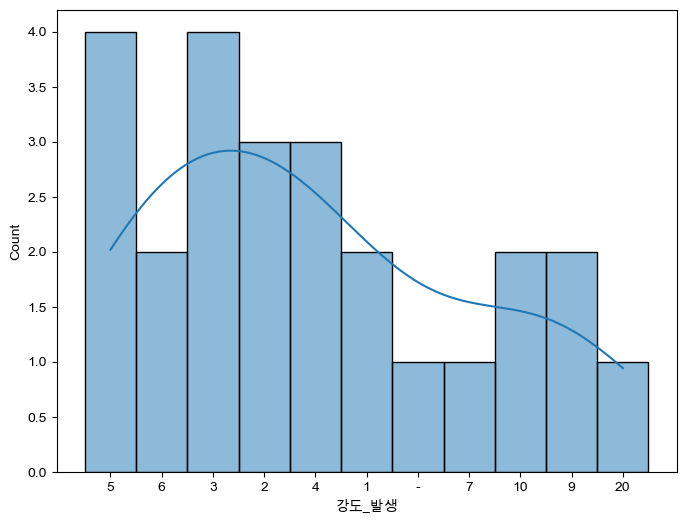

In [6]:
plt.figure(figsize=(8, 6))
sns.histplot(crime['강도_발생'], kde=True)
plt.xlabel('강도_발생')
plt.show()

In [7]:
crime['강도_발생'] = crime['강도_발생'].replace('-', np.nan)
crime['강도_발생'] = crime['강도_발생'].astype(float)
crime['강도_발생'] = crime['강도_발생'].fillna(crime['강도_발생'].median()) # 분포 확인 후 중앙값 대체

re_col =['살인_발생', '살인_검거', '강도_검거', '강도_발생', '절도_발생', 
         '절도_검거', '폭력_발생', '폭력_검거', '총합_발생', '총합_검거',]

crime[re_col] = crime[re_col].astype(int)
print(f"Columns Length: {len(crime.columns)}")
crime.dtypes

Columns Length: 11


구        object
살인_발생     int64
살인_검거     int64
강도_발생     int64
강도_검거     int64
절도_발생     int64
절도_검거     int64
폭력_발생     int64
폭력_검거     int64
총합_발생     int64
총합_검거     int64
dtype: object

In [8]:
crime.head()

,구,살인_발생,살인_검거,강도_발생,강도_검거,절도_발생,절도_검거,폭력_발생,폭력_검거,총합_발생,총합_검거
0,종로구,5,6,5,7,239,1138,1169,953,1563,1381
1,중구,3,3,6,5,212,144,1520,864,1607,1449
2,용산구,3,4,3,3,245,219,978,561,1792,1481
3,성동구,2,1,2,2,119,85,893,472,1007,851
4,광진구,2,2,5,3,238,178,1616,830,1563,1320


In [9]:
crime.isna().sum()

구        0
살인_발생    0
살인_검거    0
강도_발생    0
강도_검거    0
절도_발생    0
절도_검거    0
폭력_발생    0
폭력_검거    0
총합_발생    0
총합_검거    0
dtype: int64

In [ ]:
crime.to_csv("../data/Preprocessed_data/Crime.csv", index=False, encoding='EUC-kr')

### population Data

In [10]:
population.head()

,동별(2),세대 (세대),계 (명),계 (명).1,계 (명).2,한국인 (명),한국인 (명).1,한국인 (명).2,등록외국인 (명),등록외국인 (명).1,등록외국인 (명).2,세대당인구 (명),65세이상고령자 (명)
동별(1),,,,,,,,,,,,,
동별(1),동별(2),소계,소계,남자,여자,소계,남자,여자,소계,남자,여자,소계,소계
합계,소계,4469417,9638799,4649446,4989353,9386034,4540031,4846003,252765,109415,143350,2.10,1743696
합계,종로구,72067,150453,71890,78563,139417,67306,72111,11036,4584,6452,1.93,28764
합계,중구,64714,131793,63495,68298,121312,58659,62653,10481,4836,5645,1.87,25920
합계,용산구,107825,227106,109826,117280,213151,102312,110839,13955,7514,6441,1.98,39747


In [11]:
population = population.reset_index() # 멀티 인덱스 초기화
population = population.drop(index=0) # 0번째 index 제거
population = population.rename(columns={ 
    '동별(2)': '구',
    '계 (명).1': '남자',
    '계 (명).2': '여자',
    '등록외국인 (명).1': '외국인_남자',
    '등록외국인 (명).2': '외국인_여자',
    '세대당인구 (명)': '세대당인구',
    '65세이상고령자 (명)': '고령자수',
    '계 (명)': '총인구수'}) # 컬럼 이름 변경

population = population[~population['구'].isin(['소계', '합계'])] # '소계', '합계' 제거
use_cols = ['구', '총인구수', '남자', '여자', '외국인_남자', '외국인_여자', '고령자수', '세대당인구'] # 필요 컬럼 선택
population = population[use_cols].reset_index(drop=True)
population

,구,총인구수,남자,여자,외국인_남자,외국인_여자,고령자수,세대당인구
0,종로구,150453,71890,78563,4584,6452,28764,1.93
1,중구,131793,63495,68298,4836,5645,25920,1.87
2,용산구,227106,109826,117280,7514,6441,39747,1.98
3,성동구,284766,137620,147146,3101,4304,49462,2.08
4,광진구,351180,167562,183618,6285,9341,56819,1.97
5,동대문구,359873,174120,185753,6774,11950,67030,1.97
6,중랑구,387470,189462,198008,2090,3225,78955,2.03
7,성북구,438168,208682,229486,4511,8055,80414,2.16
8,강북구,292977,141185,151792,1671,3193,68617,2.01
9,도봉구,309494,149675,159819,879,1667,70436,2.22


In [12]:
population.isna().sum()

구         0
총인구수      0
남자        0
여자        0
외국인_남자    0
외국인_여자    0
고령자수      0
세대당인구     0
dtype: int64

In [ ]:
population.to_csv("../data/Preprocessed_data/Population.csv", index=False, encoding='EUC-kr')

### Age pop Data

In [13]:
age_pop.head()

,자치구별(2),성별(1),계,계.1,계.2,계.3,계.4,계.5,계.6,계.7,...,계.11,계.12,계.13,계.14,계.15,계.16,계.17,계.18,계.19,계.20
자치구별(1),,,,,,,,,,,,,,,,,,,,,
자치구별(1),자치구별(2),성별(1),소계,0~4세,5~9세,10~14세,15~19세,20~24세,25~29세,30~34세,...,50~54세,55~59세,60~64세,65~69세,70~74세,75~79세,80~84세,85~89세,90~94세,95세 이상+
합계,소계,남자,4535176,112776,152542,174961,189020,272537,393019,389565,...,390855,335926,345979,278273,189682,137056,93932,36686,9258,1823
합계,소계,여자,4865189,105857,145506,165579,185033,326705,432735,387584,...,403373,356733,381235,319790,224276,172265,127202,66037,24318,6718
합계,종로구,남자,70004,1235,1705,2121,3428,5563,7099,5836,...,6049,5411,5671,4303,2747,2112,1713,768,220,54
합계,종로구,여자,76680,1170,1737,2169,3230,7745,7581,5580,...,6295,5822,5748,4548,3252,2891,2482,1302,476,145


In [14]:
age_pop = age_pop.reset_index() # 멀티 인덱스 초기화 / 1 번째 인덱스 삭제
age_pop = age_pop.drop(columns=['자치구별(1)'])
age_pop.columns = age_pop.iloc[0]
age_pop = age_pop.drop(index=[0, 1])
age_pop = age_pop.rename(columns={'자치구별(2)':'구'})

age_pops = age_pop[age_pop['구'] != '소계'].drop(columns=['성별(1)', '소계'])
dtpye_cols = age_pops.columns.drop('구') # Columns
age_pops[dtpye_cols] = age_pops[dtpye_cols].astype(int)
age_pops = age_pops.groupby('구').sum().reset_index()
age_pops

,구,0~4세,5~9세,10~14세,15~19세,20~24세,25~29세,30~34세,35~39세,40~44세,...,50~54세,55~59세,60~64세,65~69세,70~74세,75~79세,80~84세,85~89세,90~94세,95세 이상+
0,강남구,11197,19103,27929,27884,24571,36105,38486,35519,45415,...,46875,34217,32046,29112,21199,15801,9448,4466,1678,456
1,강동구,13050,17634,19043,18344,21225,32485,34558,32830,38395,...,36247,32788,37020,30936,20623,13981,8747,4027,1596,435
2,강북구,4814,7141,8795,10185,17076,21750,19080,16240,19543,...,25339,23375,25446,21483,16098,13065,9829,4261,1175,292
3,강서구,13657,17896,19858,20489,27561,49835,53388,42707,44819,...,43240,38131,43473,36536,24939,17309,11507,5513,2036,542
4,관악구,7463,9628,10940,14335,40533,75901,56257,34477,32665,...,35229,31958,34302,28402,21439,16200,11594,4680,1360,330
5,광진구,6536,8975,10809,12855,28064,38518,32528,24137,24822,...,27948,25540,26216,20252,13273,9924,7139,3341,1038,291
6,구로구,10867,13062,14000,14520,20292,31856,35213,31793,32871,...,36531,34498,37042,30368,20852,14593,10059,4439,1341,328
7,금천구,4963,5829,6171,7067,11672,24120,23722,17554,16776,...,21437,21961,23197,17406,11485,8220,5657,2437,758,195
8,노원구,10681,15869,20976,25734,35730,33482,31222,28714,35632,...,46018,37595,39255,32509,22093,16527,12466,6172,2043,527
9,도봉구,5747,8634,10327,11597,16324,20898,19584,17481,20787,...,27167,25444,28103,23681,15929,12347,9616,4396,1490,383


In [15]:
pivot = age_pop[['구', '소계', '성별(1)']].pivot_table(index='구', columns='성별(1)', values='소계', aggfunc='sum').reset_index()
pivot.columns.name = None
pivot = pivot[~pivot['구'].isin(['소계'])].reset_index(drop=True)
pivot[['남자', '여자']] = pivot[['남자', '여자']].astype(int)
pivot['총인구수'] = pivot['남자'] + pivot['여자']
pivot = pivot[['구', '총인구수', '남자', '여자']]
pivot

,구,총인구수,남자,여자
0,강남구,508057,243024,265033
1,강동구,447617,218461,229156
2,강북구,284998,136977,148021
3,강서구,553209,264442,288767
4,관악구,497498,248796,248702
5,광진구,345623,165396,180227
6,구로구,425209,211160,214049
7,금천구,246497,124749,121748
8,노원구,492070,235844,256226
9,도봉구,300976,144935,156041


In [16]:
age_pop = pd.merge(pivot, age_pops, on='구', how='left')
age_pop.head()

,구,총인구수,남자,여자,0~4세,5~9세,10~14세,15~19세,20~24세,25~29세,...,50~54세,55~59세,60~64세,65~69세,70~74세,75~79세,80~84세,85~89세,90~94세,95세 이상+
0,강남구,508057,243024,265033,11197,19103,27929,27884,24571,36105,...,46875,34217,32046,29112,21199,15801,9448,4466,1678,456
1,강동구,447617,218461,229156,13050,17634,19043,18344,21225,32485,...,36247,32788,37020,30936,20623,13981,8747,4027,1596,435
2,강북구,284998,136977,148021,4814,7141,8795,10185,17076,21750,...,25339,23375,25446,21483,16098,13065,9829,4261,1175,292
3,강서구,553209,264442,288767,13657,17896,19858,20489,27561,49835,...,43240,38131,43473,36536,24939,17309,11507,5513,2036,542
4,관악구,497498,248796,248702,7463,9628,10940,14335,40533,75901,...,35229,31958,34302,28402,21439,16200,11594,4680,1360,330


In [17]:
infant_cols = ['0~4세', '5~9세']
teen_cols   = ['10~14세', '15~19세']
twenties    = ['20~24세', '25~29세']
thirties   = ['30~34세', '35~39세']
forties    = ['40~44세', '45~49세']
fifties    = ['50~54세', '55~59세']
elderly    = ['60~64세','65~69세','70~74세',
              '75~79세','80~84세','85~89세','90~94세','95세 이상+']

age_pop['어린이']    = age_pop[infant_cols].sum(axis=1)
age_pop['10대']     = age_pop[teen_cols].sum(axis=1)
age_pop['20대']     = age_pop[twenties].sum(axis=1)
age_pop['30대']     = age_pop[thirties].sum(axis=1)
age_pop['40대']     = age_pop[forties].sum(axis=1)
age_pop['50대']     = age_pop[fifties].sum(axis=1)
age_pop['고령자수']  = age_pop[elderly].sum(axis=1)

drop_cols = infant_cols + teen_cols + twenties + thirties + forties + fifties + elderly
age_pop = age_pop.drop(columns=drop_cols)

age_pop = age_pop[['구','총인구수','남자','여자', '어린이','10대','20대','30대','40대','50대','고령자수']]
age_pop.head()

,구,총인구수,남자,여자,어린이,10대,20대,30대,40대,50대,고령자수
0,강남구,508057,243024,265033,30300,55813,60676,74005,91965,81092,114206
1,강동구,447617,218461,229156,30684,37387,53710,67388,72048,69035,117365
2,강북구,284998,136977,148021,11955,18980,38826,35320,39554,48714,91649
3,강서구,553209,264442,288767,31553,40347,77396,96095,84592,81371,141855
4,관악구,497498,248796,248702,17091,25275,116434,90734,62470,67187,118307


In [18]:
age_pop.isna().sum()

구       0
총인구수    0
남자      0
여자      0
어린이     0
10대     0
20대     0
30대     0
40대     0
50대     0
고령자수    0
dtype: int64

In [20]:
age_pop.to_csv("../data/Preprocessed_data/Age_pop.csv", index=False, encoding='EUC-kr')

### Money Data

In [19]:
money.head(3)

,기준_년분기_코드,행정동_코드,행정동_코드_명,월_평균_소득_금액,소득_구간_코드,지출_총금액,식료품_지출_총금액,의류_신발_지출_총금액,생활용품_지출_총금액,의료비_지출_총금액,교통_지출_총금액,교육_지출_총금액,유흥_지출_총금액,여가_문화_지출_총금액,기타_지출_총금액,음식_지출_총금액
0,20231,11215,광진구,3192971,7,94779593000,20890784000,2984254000,2016273000,12347919000,5956030000,3158914000,4697744000,6487302000,5636812000,30603561000
1,20231,11440,마포구,3832436,8,1024107094000,30751673000,7053703000,2474929000,18507505000,3428960000,8466173000,9589375000,881500424000,8679864000,53654488000
2,20231,11530,구로구,2994059,7,1343755688000,24181621000,1395886000,2163266000,22077117000,3302443000,3962500000,3135865000,1259516797000,2954217000,21065976000


In [20]:
money.columns

Index(['기준_년분기_코드', '행정동_코드', '행정동_코드_명', '월_평균_소득_금액', '소득_구간_코드', '지출_총금액',
       '식료품_지출_총금액', '의류_신발_지출_총금액', '생활용품_지출_총금액', '의료비_지출_총금액', '교통_지출_총금액',
       '교육_지출_총금액', '유흥_지출_총금액', '여가_문화_지출_총금액', '기타_지출_총금액', '음식_지출_총금액'],
      dtype='object')

In [21]:
money['기준_년분기_코드'].unique()

array([20231, 20223, 20222, 20241, 20242, 20243, 20244, 20221, 20213,
       20212, 20211, 20204, 20203, 20202, 20201, 20194, 20193, 20192,
       20191, 20214, 20224, 20232, 20233, 20234])

In [22]:
money_23 = money[money['기준_년분기_코드'].between(20231, 20234)]
money_23 = money_23[['기준_년분기_코드', '행정동_코드_명', '월_평균_소득_금액']]
money_23

,기준_년분기_코드,행정동_코드_명,월_평균_소득_금액
0,20231,광진구,3192971
1,20231,마포구,3832436
2,20231,구로구,2994059
3,20231,영등포구,3604887
4,20231,관악구,2771927
...,...,...,...
570,20234,서초구,4912401
571,20234,중구,3513603
572,20234,광진구,3192971
573,20234,강서구,3160623


In [23]:
money_23 = money_23.groupby('행정동_코드_명')['월_평균_소득_금액'].mean().reset_index()
money_23 = money_23.rename(columns={'행정동_코드_명':'구', '월_평균_소득_금액':'월_평균_소득(원)'})
money_23['월_평균_소득(원)'] = money_23['월_평균_소득(원)'].astype(int)
money_23

,구,월_평균_소득(원)
0,강남구,4943841
1,강동구,3292857
2,강북구,2547460
3,강서구,3160623
4,관악구,2771927
5,광진구,3192971
6,구로구,2994059
7,금천구,2632285
8,노원구,3195375
9,도봉구,2785111


In [26]:
money_23.to_csv("../data/Preprocessed_data/Month_mean_money.csv", index=False, encoding='EUC-kr')

### Merge

In [24]:
pop_crime =  pd.merge(age_pop, crime, on='구', how='left')
pop_crime_money = pd.merge(pop_crime, money_23, on='구', how='left')

print(f"Total Data: {pop_crime_money.shape}")
print(f"Total Missing: {pop_crime_money.isna().sum().sum()}")
print(f"Missing Columns: {[col for col in pop_crime_money.columns if pop_crime_money[col].isna().any()]}")
pop_crime_money.head()         

Total Data: (25, 22)
Total Missing: 0
Missing Columns: []


,구,총인구수,남자,여자,어린이,10대,20대,30대,40대,50대,...,살인_검거,강도_발생,강도_검거,절도_발생,절도_검거,폭력_발생,폭력_검거,총합_발생,총합_검거,월_평균_소득(원)
0,강남구,508057,243024,265033,30300,55813,60676,74005,91965,81092,...,11,20,18,678,567,2480,1284,3571,3112,4943841
1,강동구,447617,218461,229156,30684,37387,53710,67388,72048,69035,...,6,5,4,144,122,1676,980,1569,1383,3292857
2,강북구,284998,136977,148021,11955,18980,38826,35320,39554,48714,...,7,1,1,141,102,917,730,1431,1302,2547460
3,강서구,553209,264442,288767,31553,40347,77396,96095,84592,81371,...,2,6,4,300,225,1794,1243,2195,2070,3160623
4,관악구,497498,248796,248702,17091,25275,116434,90734,62470,67187,...,17,10,10,328,268,2013,1166,2402,2035,2771927


In [25]:
pop_crime_money.columns

Index(['구', '총인구수', '남자', '여자', '어린이', '10대', '20대', '30대', '40대', '50대',
       '고령자수', '살인_발생', '살인_검거', '강도_발생', '강도_검거', '절도_발생', '절도_검거', '폭력_발생',
       '폭력_검거', '총합_발생', '총합_검거', '월_평균_소득(원)'],
      dtype='object')

In [26]:
pop_crime_money.dtypes

구             object
총인구수           int64
남자             int64
여자             int64
어린이            int64
10대            int64
20대            int64
30대            int64
40대            int64
50대            int64
고령자수           int64
살인_발생          int64
살인_검거          int64
강도_발생          int64
강도_검거          int64
절도_발생          int64
절도_검거          int64
폭력_발생          int64
폭력_검거          int64
총합_발생          int64
총합_검거          int64
월_평균_소득(원)     int64
dtype: object

In [27]:
# 인구
pop_crime_money['남성_비율'] = pop_crime_money['남자'] / pop_crime_money['총인구수']
pop_crime_money['여성_비율'] = pop_crime_money['여자'] / pop_crime_money['총인구수']
pop_crime_money['어린이_비율'] = pop_crime_money['어린이'] / pop_crime_money['총인구수']
pop_crime_money['10대_비율'] = pop_crime_money['10대'] / pop_crime_money['총인구수']
pop_crime_money['20대_비율'] = pop_crime_money['20대'] / pop_crime_money['총인구수']
pop_crime_money['30대_비율'] = pop_crime_money['30대'] / pop_crime_money['총인구수']
pop_crime_money['40대_비율'] = pop_crime_money['40대'] / pop_crime_money['총인구수']
pop_crime_money['50대_비율'] = pop_crime_money['50대'] / pop_crime_money['총인구수']
pop_crime_money['고령자_비율'] = pop_crime_money['고령자수']  / pop_crime_money['총인구수']

# 인구대비 범죄율
pop_crime_money['살인율'] = pop_crime_money['살인_발생'] / pop_crime_money['총인구수']
pop_crime_money['강도율'] = pop_crime_money['강도_발생'] / pop_crime_money['총인구수']
pop_crime_money['절도율'] = pop_crime_money['절도_발생'] / pop_crime_money['총인구수']
pop_crime_money['폭력율'] = pop_crime_money['폭력_발생'] / pop_crime_money['총인구수']

# 검거율 (0 나누기 방지)
pop_crime_money['살인_검거율'] = pop_crime_money['살인_검거'] / pop_crime_money['살인_발생'].replace(0, np.nan)
pop_crime_money['강도_검거율'] = pop_crime_money['강도_검거'] / pop_crime_money['강도_발생'].replace(0, np.nan)
pop_crime_money['절도_검거율'] = pop_crime_money['절도_검거'] / pop_crime_money['절도_발생'].replace(0, np.nan)
pop_crime_money['폭력_검거율'] = pop_crime_money['폭력_검거'] / pop_crime_money['폭력_발생'].replace(0, np.nan)
pop_crime_money['총_검거율'] = pop_crime_money['총합_검거'] / pop_crime_money['총합_발생'].replace(0, np.nan)

# 기존 피처 제거
cols_to_drop = [
    '남자', '여자', '어린이', '10대', '20대', '30대', '40대', '50대','고령자수',
    '살인_발생','살인_검거','강도_발생','강도_검거', '절도_발생', '절도_검거',
    '폭력_발생','폭력_검거', '총합_검거']

order_cols = [
    '구', '총인구수', '남성_비율', '여성_비율', '어린이_비율', '10대_비율', '20대_비율', '30대_비율', '40대_비율', '50대_비율', '고령자_비율',
    '월_평균_소득(원)', '총합_발생', '살인율', '강도율', '절도율', '폭력율', '살인_검거율', '강도_검거율', '절도_검거율', '폭력_검거율', '총_검거율']

pop_crime_money = pop_crime_money.drop(columns=cols_to_drop)
pop_crime_money = pop_crime_money[order_cols]
pop_crime_money.head()

,구,총인구수,남성_비율,여성_비율,어린이_비율,10대_비율,20대_비율,30대_비율,40대_비율,50대_비율,...,총합_발생,살인율,강도율,절도율,폭력율,살인_검거율,강도_검거율,절도_검거율,폭력_검거율,총_검거율
0,강남구,508057,0.478340,0.521660,0.059639,0.109856,0.119428,0.145663,0.181013,0.159612,...,3571,0.000028,0.000039,0.001334,0.004881,0.785714,0.900000,0.836283,0.517742,0.871465
1,강동구,447617,0.488053,0.511947,0.068550,0.083525,0.119991,0.150548,0.160959,0.154228,...,1569,0.000009,0.000011,0.000322,0.003744,1.500000,0.800000,0.847222,0.584726,0.881453
2,강북구,284998,0.480624,0.519376,0.041948,0.066597,0.136233,0.123931,0.138787,0.170928,...,1431,0.000025,0.000004,0.000495,0.003218,1.000000,1.000000,0.723404,0.796074,0.909853
3,강서구,553209,0.478015,0.521985,0.057036,0.072933,0.139904,0.173705,0.152911,0.147089,...,2195,0.000002,0.000011,0.000542,0.003243,2.000000,0.666667,0.750000,0.692865,0.943052
4,관악구,497498,0.500094,0.499906,0.034354,0.050804,0.234039,0.182381,0.125568,0.135050,...,2402,0.000032,0.000020,0.000659,0.004046,1.062500,1.000000,0.817073,0.579235,0.847211


In [28]:
pop_crime_money.columns

Index(['구', '총인구수', '남성_비율', '여성_비율', '어린이_비율', '10대_비율', '20대_비율', '30대_비율',
       '40대_비율', '50대_비율', '고령자_비율', '월_평균_소득(원)', '총합_발생', '살인율', '강도율',
       '절도율', '폭력율', '살인_검거율', '강도_검거율', '절도_검거율', '폭력_검거율', '총_검거율'],
      dtype='object')

In [29]:
pop_crime_money.isna().sum()

구             0
총인구수          0
남성_비율         0
여성_비율         0
어린이_비율        0
10대_비율        0
20대_비율        0
30대_비율        0
40대_비율        0
50대_비율        0
고령자_비율        0
월_평균_소득(원)    0
총합_발생         0
살인율           0
강도율           0
절도율           0
폭력율           0
살인_검거율        0
강도_검거율        0
절도_검거율        0
폭력_검거율        0
총_검거율         0
dtype: int64

In [31]:
pop_crime_money.to_csv("../data/Preprocessed_data/Metrics.csv", index=False, encoding='EUC-kr')

### Graden Data

In [32]:
garden.head(1)

,연번,공원명,공원개요,면적,개원일,주요시설,주요식물,안내도,오시는길,이용시참고사항,이미지,지역,공원주소,관리부서,전화번호,X좌표(GRS80TM),Y좌표(GRS80TM),X좌표(WGS84),Y좌표(WGS84),바로가기
0,1,남산공원,남산공원은 도심에 위치하여 서울시민에게 맑은 공기를 제공하는 자연휴식처이며 산책 꽃...,2896887㎡ 임 야 : 2454140㎡ 녹지대 및 기타시설 : 442747㎡,1968.9.10,기반시설 : 광장 45950㎡ 도로 108530㎡ 산책로 6.7㎞ (북측:3.7㎞/...,소나무 단풍 아카시아 상수리나무 등 191종 2881870주,http://parks.seoul.go.kr/upload/seditorMulti/2...,명동역(남산케이블카 와룡묘 서울애니메이션센터 방면) 도보 명동역 3번출구 → 퍼시픽...,남산공원 차량통행 금지안내 2005년 5월 1일부터 남산공원에 일반승용차 택시 통행...,http://parks.seoul.go.kr/file/info/view.do?fId...,중구,서울특별시 중구 삼일대로 231(예장동),중부공원여가센터,02-3783-5900,198364.107,450395.554,126.990377,37.55014,http://parks.seoul.go.kr/template/sub/namsan.do


In [33]:
garden.columns

Index(['연번', '공원명', '공원개요', '면적', '개원일', '주요시설', '주요식물', '안내도', '오시는길',
       '이용시참고사항', '이미지', '지역', '공원주소', '관리부서', '전화번호', 'X좌표(GRS80TM)',
       'Y좌표(GRS80TM)', 'X좌표(WGS84)', 'Y좌표(WGS84)', '바로가기'],
      dtype='object')

In [34]:
drop_cols = ['연번', '공원개요', '면적', '개원일', '안내도', '오시는길', 
             '이용시참고사항', '이미지', '공원주소', '관리부서', '전화번호', 
             '바로가기', 'X좌표(GRS80TM)', 'Y좌표(GRS80TM)', '주요시설', '주요식물']

garden = garden.drop(columns=drop_cols)
garden = garden.rename(columns={'지역':'구', 'X좌표(WGS84)':'경도', 'Y좌표(WGS84)':'위도'})
garden

,공원명,구,경도,위도
0,남산공원,중구,126.990377,37.550140
1,길동생태공원,강동구,127.154779,37.540394
2,서울대공원,과천시,127.019846,37.426449
3,서울숲,성동구,127.041798,37.543072
4,월드컵공원,마포구,126.878907,37.571805
...,...,...,...,...
126,문화비축기지,마포구,126.893246,37.571718
127,경춘선숲길,NaN,127.076482,37.627077
128,율현공원,강남구,127.115594,37.472332
129,서울로7017,중구,NaN,NaN


In [35]:
garden.isna().sum()

공원명    1
구      1
경도     1
위도     1
dtype: int64

In [36]:
# 결측치가 있는 컬럼
cols_with_na = garden.columns[garden.isna().any()]
garden_na_df = garden[cols_with_na]

garden_na_rows = garden[garden[cols_with_na].isna().any(axis=1)]
garden_na_rows

,공원명,구,경도,위도
69,NaN,마포구,126.911414,37.546797
127,경춘선숲길,NaN,127.076482,37.627077
129,서울로7017,중구,NaN,NaN


In [37]:
garden['구'] = garden['구'].fillna('노원구') # 경춘선숲길은 노원구로 확인됨
garden['공원명'] = garden['공원명'].fillna('양화진 외국인 선교사 묘원') # 위도, 경도 검색 결과
garden['위도'] = garden['위도'].fillna(37.5567137) # 공원명 검색 후 위도, 경도 맵핑
garden['경도'] = garden['경도'].fillna(126.9690573)
garden.isna().sum()

공원명    0
구      0
경도     0
위도     0
dtype: int64

In [38]:
hangang_name = [
    {"구": "강동구", "공원명": "광나루한강공원", "위도": 37.551175, "경도": 127.122202},
    {"구": "송파구", "공원명": "잠실한강공원", "위도": 37.520000, "경도": 127.080000},
    {"구": "광진구", "공원명": "뚝섬한강공원", "위도": 37.531000, "경도": 127.066000},
    {"구": "서초구", "공원명": "잠원한강공원", "위도": 37.521870, "경도": 127.012297},
    {"구": "용산구", "공원명": "이촌한강공원", "위도": 337.5169202, "경도": 126.9717022},
    {"구": "서초구", "공원명": "반포한강공원", "위도": 37.5106226, "경도": 126.9959627},
    {"구": "마포구", "공원명": "망원한강공원", "위도": 37.5527919, "경도": 126.8985613},
    {"구": "영등포구", "공원명": "여의도한강공원", "위도": 37.5267106, "경도": 126.9347112},
    {"구": "마포구", "공원명": "난지한강공원", "위도": 37.5667873, "경도": 126.8780119},
    {"구": "강서구", "공원명": "강서한강공원", "위도": 37.586094, "경도": 126.817160},
    {"구": "영등포구", "공원명": "양화한강공원", "위도": 37.5383005, "경도": 126.902265},]

hangang = pd.DataFrame(hangang_name)
hangang

,구,공원명,위도,경도
0,강동구,광나루한강공원,37.551175,127.122202
1,송파구,잠실한강공원,37.520000,127.080000
2,광진구,뚝섬한강공원,37.531000,127.066000
3,서초구,잠원한강공원,37.521870,127.012297
4,용산구,이촌한강공원,337.516920,126.971702
5,서초구,반포한강공원,37.510623,126.995963
6,마포구,망원한강공원,37.552792,126.898561
7,영등포구,여의도한강공원,37.526711,126.934711
8,마포구,난지한강공원,37.566787,126.878012
9,강서구,강서한강공원,37.586094,126.817160


In [39]:
garden = pd.concat([garden, hangang], ignore_index=True)
garden

,공원명,구,경도,위도
0,남산공원,중구,126.990377,37.550140
1,길동생태공원,강동구,127.154779,37.540394
2,서울대공원,과천시,127.019846,37.426449
3,서울숲,성동구,127.041798,37.543072
4,월드컵공원,마포구,126.878907,37.571805
...,...,...,...,...
137,망원한강공원,마포구,126.898561,37.552792
138,여의도한강공원,영등포구,126.934711,37.526711
139,난지한강공원,마포구,126.878012,37.566787
140,강서한강공원,강서구,126.817160,37.586094


In [40]:
oder_col = ['구', '공원명', '위도', '경도'] # 순서 재배치
garden = garden[oder_col]
garden

,구,공원명,위도,경도
0,중구,남산공원,37.550140,126.990377
1,강동구,길동생태공원,37.540394,127.154779
2,과천시,서울대공원,37.426449,127.019846
3,성동구,서울숲,37.543072,127.041798
4,마포구,월드컵공원,37.571805,126.878907
...,...,...,...,...
137,마포구,망원한강공원,37.552792,126.898561
138,영등포구,여의도한강공원,37.526711,126.934711
139,마포구,난지한강공원,37.566787,126.878012
140,강서구,강서한강공원,37.586094,126.817160


In [41]:
garden = garden[garden['구'] != '과천시'] # 과천시는 서울이 아님
garden[garden['구'] == '과천시'] # 확인

,구,공원명,위도,경도


In [42]:
# 중복 체크
garden.duplicated(subset=['공원명', '위도', '경도']).sum()

0

In [43]:
garden.isna().sum()

구      0
공원명    0
위도     0
경도     0
dtype: int64

In [44]:
garden.to_csv("../data/Preprocessed_data/Garden.csv", index=False, encoding='EUC-kr')

### House Price Data

In [4]:
house_price

,자치구별(1),자치구별(2),시점,아파트
0,서울시,소계,2007. 01,83.1
1,서울시,소계,2007. 02,83.6
2,서울시,소계,2007. 03,84.0
3,서울시,소계,2007. 04,84.3
4,서울시,소계,2007. 05,84.3
...,...,...,...,...
5663,서울시,강동구,2019,113.6
5664,서울시,강동구,2020,116.5
5665,서울시,강동구,2021,104.4
5666,서울시,강동구,2022,96.5


In [5]:
house_price.dtypes

자치구별(1)     object
자치구별(2)     object
시점          object
아파트        float64
dtype: object

In [6]:
house_price.isna().sum()

자치구별(1)    0
자치구별(2)    0
시점         0
아파트        0
dtype: int64

In [7]:
house_price['Year'] = pd.to_datetime(house_price['시점']).dt.year
house_price['Month'] = pd.to_datetime(house_price['시점']).dt.month
house_price = house_price.rename(columns={'자치구별(2)': '구', '아파트': '주택가격지수'})
house_price = house_price.drop(columns=['시점', '자치구별(1)'])
house_price = house_price[['Year', 'Month', '구', '주택가격지수']]
house_price = house_price[house_price['구'] != '소계']

house_price

,Year,Month,구,주택가격지수
218,2007,1,종로구,77.4
219,2007,2,종로구,78.0
220,2007,3,종로구,78.3
221,2007,4,종로구,78.4
222,2007,5,종로구,78.6
...,...,...,...,...
5663,2019,1,강동구,113.6
5664,2020,1,강동구,116.5
5665,2021,1,강동구,104.4
5666,2022,1,강동구,96.5


In [6]:
house_price.to_csv("../data/Preprocessed_data/주택가격지수.csv", index=False)

### Land Price Data

In [8]:
land_price.head()

,자치구별,구분별,항목,단위,2007. 01 월,2007. 02 월,2007. 03 월,2007. 04 월,2007. 05 월,2007. 06 월,...,2014 년,2015 년,2016 년,2017 년,2018 년,2019 년,2020 년,2021 년,2022 년,2023 년
0,서울시,평균,지가변동률,NaN,0.517,0.462,0.402,0.347,0.342,0.378,...,2.662,2.688,2.974,4.315,6.114,5.287,4.803,5.313,3.064,1.106
1,서울시,주거,지가변동률,NaN,0.523,0.479,0.402,0.338,0.330,0.372,...,2.936,2.958,3.201,4.504,6.506,5.249,4.822,5.259,2.861,1.041
2,서울시,상업,지가변동률,NaN,0.528,0.408,0.403,0.384,0.391,0.405,...,2.045,1.866,2.370,3.774,4.861,5.545,4.885,5.631,3.728,1.437
3,서울시,공업,지가변동률,NaN,0.525,0.448,0.421,0.386,0.389,0.429,...,1.761,2.197,2.248,4.560,5.896,5.839,5.057,5.793,4.119,1.082
4,서울시,녹지,지가변동률,NaN,0.395,0.402,0.384,0.286,0.296,0.315,...,1.072,1.548,1.784,2.030,4.138,3.078,2.756,3.037,1.905,0.314


In [9]:
land_price.dtypes

자치구별           object
구분별            object
항목             object
단위            float64
2007. 01 월    float64
               ...   
2019 년        float64
2020 년        float64
2021 년         object
2022 년         object
2023 년         object
Length: 222, dtype: object

In [10]:
land_price.isna().sum()

자치구별            0
구분별             0
항목              0
단위            440
2007. 01 월    259
             ... 
2019 년        234
2020 년        238
2021 년        155
2022 년        155
2023 년          0
Length: 222, dtype: int64

In [11]:
land_price['항목'].unique()

array(['지가변동률'], dtype=object)

In [12]:
# 날짜형 컬럼만 추출
date_cols = [col for col in land_price.columns if '월' in col or '년' in col]

# melt 사용
melted = land_price.melt(
    id_vars=['자치구별', '구분별'], 
    value_vars=date_cols,
    var_name='date', 
    value_name='지가변동률')

# 컬럼 정리
melted = melted.rename(columns={'자치구별': '구'})

melted['date'] = melted['date'].str.replace(' ', '').str.replace('월', '').str.replace('년', '')
melted['date'] = pd.to_datetime(melted['date'], format='%Y.%m', errors='coerce')  # 에러는 NaT 처리
melted['Year'] = melted['date'].dt.year
melted['Month'] = melted['date'].dt.month

melted = melted[['Year', 'Month', '구', '지가변동률']].dropna(subset=['Year', 'Month'])
melted = melted[melted['구'] != '서울시']
melted

,Year,Month,구,지가변동률
17,2007.0,1.0,종로구,0.512
18,2007.0,1.0,종로구,0.599
19,2007.0,1.0,종로구,0.448
20,2007.0,1.0,종로구,NaN
21,2007.0,1.0,종로구,0.294
...,...,...,...,...
88435,2023.0,9.0,강동구,0.021
88436,2023.0,9.0,강동구,-
88437,2023.0,9.0,강동구,0.085
88438,2023.0,9.0,강동구,0.14


In [13]:
melted = melted.sort_values(by=['구', 'Year', 'Month'])
melted['지가변동률'] = pd.to_numeric(melted['지가변동률'], errors='coerce')

melted['지가변동률'] = (
    melted.groupby('구')['지가변동률']
    .transform(lambda x: x.interpolate(method='linear', limit_direction='both')))
melted.isna().sum()

Year     0
Month    0
구        0
지가변동률    0
dtype: int64

In [14]:
melted['Year'] = melted['Year'].astype(int)
melted['Month'] = melted['Month'].astype(int)
melted

,Year,Month,구,지가변동률
391,2007,1,강남구,0.372
392,2007,1,강남구,0.344
393,2007,1,강남구,0.467
394,2007,1,강남구,0.408
395,2007,1,강남구,0.349
...,...,...,...,...
88131,2023,9,중랑구,0.220
88132,2023,9,중랑구,0.144
88133,2023,9,중랑구,0.105
88134,2023,9,중랑구,0.105


In [17]:
melted.to_csv("../data/Preprocessed_data/지가번동률.csv", index=False)

### Interest Rate Data

In [15]:
interest_rate.head()

,시점,대출평균 1) (연%),기업대출 (연리%),대기업대출 (연리%),중소기업대출 (연리%),운전자금대출 (연리%),시설자금대출 (연리%),상업어음할인 (연리%),기업일반자금대출 (연리%),가계대출 (연리%),소액대출 (500만원 이하) (연리%),주택담보대출 (연리%),고정형 주택담보대출 3) (연리%),변동형 주택담보대출 3) (연리%),예・적금담보대출 (연리%),보증대출 (연리%),전세자금대출 (연리%),일반신용대출 2) (연리%),집단대출 2) (연리%),공공및기타부문대출 (연리%)
0,2007.01,6.32,6.39,5.85,6.49,6.37,6.69,7.04,6.55,6.20,6.36,6.11,-,-,5.87,5.94,-,7.18,5.61,5.55
1,2007.02,6.34,6.43,5.86,6.53,6.40,6.74,7.03,6.61,6.25,6.28,6.18,-,-,5.87,6.03,-,7.11,5.69,5.13
2,2007.03,6.37,6.41,5.84,6.53,6.40,6.49,6.89,6.56,6.32,6.31,6.20,-,-,5.90,5.76,-,7.42,5.71,5.30
3,2007.04,6.35,6.37,5.85,6.49,6.36,6.55,6.98,6.56,6.30,6.46,6.13,-,-,5.98,5.77,-,7.34,5.64,5.71
4,2007.05,6.48,6.51,6.11,6.60,6.47,6.93,6.96,6.71,6.39,6.61,6.17,-,-,5.98,5.98,-,7.50,5.73,6.00


In [16]:
interest_rate.columns

Index(['시점', '대출평균 1) (연%)', '기업대출 (연리%)', '대기업대출 (연리%)', '중소기업대출 (연리%)',
       '운전자금대출 (연리%)', '시설자금대출 (연리%)', '상업어음할인 (연리%)', '기업일반자금대출 (연리%)',
       '가계대출 (연리%)', '소액대출 (500만원 이하) (연리%)', '주택담보대출 (연리%)',
       '고정형 주택담보대출 3) (연리%)', '변동형 주택담보대출 3) (연리%)', '예・적금담보대출 (연리%)',
       '보증대출 (연리%)', '전세자금대출 (연리%)', '일반신용대출 2) (연리%)', '집단대출 2) (연리%)',
       '공공및기타부문대출 (연리%)'],
      dtype='object')

In [17]:
interest_rate.dtypes

시점                       float64
대출평균 1) (연%)             float64
기업대출 (연리%)               float64
대기업대출 (연리%)              float64
중소기업대출 (연리%)             float64
운전자금대출 (연리%)             float64
시설자금대출 (연리%)             float64
상업어음할인 (연리%)             float64
기업일반자금대출 (연리%)           float64
가계대출 (연리%)               float64
소액대출 (500만원 이하) (연리%)    float64
주택담보대출 (연리%)             float64
고정형 주택담보대출 3) (연리%)       object
변동형 주택담보대출 3) (연리%)       object
예・적금담보대출 (연리%)           float64
보증대출 (연리%)               float64
전세자금대출 (연리%)              object
일반신용대출 2) (연리%)          float64
집단대출 2) (연리%)            float64
공공및기타부문대출 (연리%)          float64
dtype: object

In [18]:
interest_rate.isna().sum()

시점                       0
대출평균 1) (연%)             0
기업대출 (연리%)               0
대기업대출 (연리%)              0
중소기업대출 (연리%)             0
운전자금대출 (연리%)             0
시설자금대출 (연리%)             0
상업어음할인 (연리%)             0
기업일반자금대출 (연리%)           0
가계대출 (연리%)               0
소액대출 (500만원 이하) (연리%)    0
주택담보대출 (연리%)             0
고정형 주택담보대출 3) (연리%)      0
변동형 주택담보대출 3) (연리%)      0
예・적금담보대출 (연리%)           0
보증대출 (연리%)               0
전세자금대출 (연리%)             0
일반신용대출 2) (연리%)          0
집단대출 2) (연리%)            0
공공및기타부문대출 (연리%)          0
dtype: int64

In [19]:
selected_cols = ['시점', '대출평균 1) (연%)', '주택담보대출 (연리%)', '전세자금대출 (연리%)', '일반신용대출 2) (연리%)']
interest_rate = interest_rate[selected_cols]
interest_rate

,시점,대출평균 1) (연%),주택담보대출 (연리%),전세자금대출 (연리%),일반신용대출 2) (연리%)
0,2007.01,6.32,6.11,-,7.18
1,2007.02,6.34,6.18,-,7.11
2,2007.03,6.37,6.20,-,7.42
3,2007.04,6.35,6.13,-,7.34
4,2007.05,6.48,6.17,-,7.50
...,...,...,...,...,...
213,2019.00,3.45,2.74,3.07,4.17
214,2020.00,2.80,2.50,2.55,3.26
215,2021.00,2.88,2.94,2.78,4.06
216,2022.00,4.29,4.24,4.02,6.27


In [20]:
dash_counts = (interest_rate == '-').sum()
print(dash_counts)

시점                   0
대출평균 1) (연%)         0
주택담보대출 (연리%)         0
전세자금대출 (연리%)       104
일반신용대출 2) (연리%)      0
dtype: int64


In [21]:
# 연도만 있는 행 제거 ('xxxx.00' 형식)
interest_rate['시점'] = interest_rate['시점'].map(lambda x: f"{x:.2f}")
interest_rate = interest_rate[~interest_rate['시점'].str.match(r'^\d{4}\.00$')]

# 분리
interest_rate['시점'] = pd.to_datetime(interest_rate['시점'], format='%Y.%m')
interest_rate['Year'] = interest_rate['시점'].dt.year
interest_rate['Month'] = interest_rate['시점'].dt.month
interest_rate

,시점,대출평균 1) (연%),주택담보대출 (연리%),전세자금대출 (연리%),일반신용대출 2) (연리%),Year,Month
0,2007-01-01,6.32,6.11,-,7.18,2007,1
1,2007-02-01,6.34,6.18,-,7.11,2007,2
2,2007-03-01,6.37,6.20,-,7.42,2007,3
3,2007-04-01,6.35,6.13,-,7.34,2007,4
4,2007-05-01,6.48,6.17,-,7.50,2007,5
...,...,...,...,...,...,...,...
196,2023-05-01,5.12,4.21,4.09,6.56,2023,5
197,2023-06-01,5.17,4.26,4.14,6.47,2023,6
198,2023-07-01,5.11,4.28,4.14,6.52,2023,7
199,2023-08-01,5.10,4.31,4.13,6.53,2023,8


In [22]:
interest_rate = interest_rate.replace('-', np.nan)
interest_rate = interest_rate.drop(columns=['시점'])
rate_cols = interest_rate.columns.difference(['Year', 'Month'])

# 선형 보간 (양방향)
interest_rate[rate_cols] = interest_rate[rate_cols].interpolate(method='linear', limit_direction='both')
interest_rate = interest_rate.rename(columns={
    '대출평균 1) (연%)': '평균_대출금리',
    '주택담보대출 (연리%)': '주택_담보대출금리',
    '전세자금대출 (연리%)': '전세_자금대출금리',
    '일반신용대출 2) (연리%)': '신용_대출금리'})
interest_rate = interest_rate[['Year', 'Month', '평균_대출금리', '주택_담보대출금리', '전세_자금대출금리', '신용_대출금리']]
print(f"Missing Values: {interest_rate.isna().sum().sum()}")
interest_rate

Missing Values: 96


,Year,Month,평균_대출금리,주택_담보대출금리,전세_자금대출금리,신용_대출금리
0,2007,1,6.32,6.11,NaN,7.18
1,2007,2,6.34,6.18,NaN,7.11
2,2007,3,6.37,6.20,NaN,7.42
3,2007,4,6.35,6.13,NaN,7.34
4,2007,5,6.48,6.17,NaN,7.50
...,...,...,...,...,...,...
196,2023,5,5.12,4.21,4.09,6.56
197,2023,6,5.17,4.26,4.14,6.47
198,2023,7,5.11,4.28,4.14,6.52
199,2023,8,5.10,4.31,4.13,6.53


In [23]:
# 나머지 결측값 모델로 예측
target_col = '전세_자금대출금리'

# 분리
train_data = interest_rate[interest_rate[target_col].notnull()]
test_data = interest_rate[interest_rate[target_col].isnull()]

# 피처 선택 (타겟 제외)
feature_cols = ['평균_대출금리', '주택_담보대출금리', '신용_대출금리']
X_train = train_data[feature_cols]
y_train = train_data[target_col]
X_test = test_data[feature_cols]

# 학습 및 예측
model = XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
predicted_test = model.predict(X_test)
interest_rate.loc[interest_rate[target_col].isnull(), target_col] = predicted_test

# R2 & RMSE
r2 = r2_score(y_train, y_pred_train)
rmse = mean_squared_error(y_train, y_pred_train, squared=False)
print(f'R²: {r2:.4f}')
print(f'RMSE: {rmse:.4f}')

R²: 1.0000
RMSE: 0.0018


In [24]:
# 과적합 확인
X_train, X_val, y_train, y_val = train_test_split(
    train_data[feature_cols], train_data[target_col], test_size=0.2, random_state=42)

model = XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

# 성능 평가
r2_train = r2_score(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
r2_val = r2_score(y_val, y_pred_val)
rmse_val = mean_squared_error(y_val, y_pred_val, squared=False)

print(f"[Train] R²: {r2_train:.4f}, RMSE: {rmse_train:.4f}")
print(f"[Val]   R²: {r2_val:.4f}, RMSE: {rmse_val:.4f}")

[Train] R²: 1.0000, RMSE: 0.0020
[Val]   R²: 0.9719, RMSE: 0.1150


In [25]:
print(f"Missing Values: {interest_rate.isna().sum().sum()}")
interest_rate

Missing Values: 0


,Year,Month,평균_대출금리,주택_담보대출금리,전세_자금대출금리,신용_대출금리
0,2007,1,6.32,6.11,4.925211,7.18
1,2007,2,6.34,6.18,4.925211,7.11
2,2007,3,6.37,6.20,5.006968,7.42
3,2007,4,6.35,6.13,5.006968,7.34
4,2007,5,6.48,6.17,5.006968,7.50
...,...,...,...,...,...,...
196,2023,5,5.12,4.21,4.09,6.56
197,2023,6,5.17,4.26,4.14,6.47
198,2023,7,5.11,4.28,4.14,6.52
199,2023,8,5.10,4.31,4.13,6.53


In [26]:
interest_rate['전세_자금대출금리'] = interest_rate['전세_자금대출금리'].astype('float64')
rate_cols = ['평균_대출금리', '주택_담보대출금리', '전세_자금대출금리', '신용_대출금리']
interest_rate[rate_cols] = interest_rate[rate_cols].round(2) # 소수점 통일
interest_rate

,Year,Month,평균_대출금리,주택_담보대출금리,전세_자금대출금리,신용_대출금리
0,2007,1,6.32,6.11,4.93,7.18
1,2007,2,6.34,6.18,4.93,7.11
2,2007,3,6.37,6.20,5.01,7.42
3,2007,4,6.35,6.13,5.01,7.34
4,2007,5,6.48,6.17,5.01,7.50
...,...,...,...,...,...,...
196,2023,5,5.12,4.21,4.09,6.56
197,2023,6,5.17,4.26,4.14,6.47
198,2023,7,5.11,4.28,4.14,6.52
199,2023,8,5.10,4.31,4.13,6.53


In [27]:
interest_rate[rate_cols].dtypes

평균_대출금리      float64
주택_담보대출금리    float64
전세_자금대출금리    float64
신용_대출금리      float64
dtype: object

In [35]:
interest_rate.to_csv("../data/Preprocessed_data/대출금리.csv", index=False)

### Inflation Data

In [28]:
inflation

,시점,< 0%,0-1%,1-2%,2-3%,3-4%,4-5%,5-6%,> 6%,모르겠다,...,모르겠다.2,<0%.2,0~1%.2,1~2%.2,2~3%.2,3~4%.2,4~5%.2,5~6%.2,>6%.2,모르겠다.3
0,2007.01,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
1,2007.02,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
2,2007.03,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
3,2007.04,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
4,2007.05,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,2023.05,0.3,1.8,5.9,12.2,15.5,19.2,18.2,25.3,1.7,...,-,-,-,-,-,-,-,-,-,-
197,2023.06,0.2,2.0,6.6,10.9,19.2,18.9,17.0,24.0,1.3,...,-,-,-,-,-,-,-,-,-,-
198,2023.07,0.5,2.0,7.8,14.6,18.1,18.2,15.8,21.3,1.7,...,4.2,1.3,5.7,16.5,24.3,22.0,8.9,8.3,7.9,5.1
199,2023.08,0.2,2.4,7.5,15.6,19.7,19.2,14.3,19.5,1.7,...,3.8,1.2,5.4,17.1,26.3,19.3,9.5,8.7,7.7,4.8


In [29]:
inflation.columns

Index(['시점', '< 0%', '0-1%', '1-2%', '2-3%', '3-4%', '4-5%', '5-6%', '> 6%',
       '모르겠다', '향후1년 기대인플레이션율', '-0.5~1.5%', '1.5~2.5%', '2.5~3.5%',
       '3.5~4.5%', '4.5~5.5%', '5.5~8%', '-0.5~1.5%.1', '1.5~2.0%', '2.0~2.5%',
       '2.5~3.0%', '3.0~3.5%', '3.5~4.0%', '4.0~4.5%', '4.5~5.5%.1',
       '5.5~8.0%', '<0%', '0~1%', '1~2%', '2~3%', '3~4%', '4~5%', '5~6%',
       '>6%', '모르겠다.1', '<0%.1', '0~1%.1', '1~2%.1', '2~3%.1', '3~4%.1',
       '4~5%.1', '5~6%.1', '>6%.1', '모르겠다.2', '<0%.2', '0~1%.2', '1~2%.2',
       '2~3%.2', '3~4%.2', '4~5%.2', '5~6%.2', '>6%.2', '모르겠다.3'],
      dtype='object')

In [30]:
inflation = inflation[['시점', '향후1년 기대인플레이션율']]
inflation

,시점,향후1년 기대인플레이션율
0,2007.01,3.0
1,2007.02,2.9
2,2007.03,3.0
3,2007.04,2.9
4,2007.05,2.9
...,...,...
196,2023.05,3.5
197,2023.06,3.5
198,2023.07,3.3
199,2023.08,3.3


In [31]:
inflation.isna().sum()

시점               0
향후1년 기대인플레이션율    0
dtype: int64

In [33]:
inflation['시점'].unique()

array([2007.01, 2007.02, 2007.03, 2007.04, 2007.05, 2007.06, 2007.07,
       2007.08, 2007.09, 2007.1 , 2007.11, 2007.12, 2008.01, 2008.02,
       2008.03, 2008.04, 2008.05, 2008.06, 2008.07, 2008.08, 2008.09,
       2008.1 , 2008.11, 2008.12, 2009.01, 2009.02, 2009.03, 2009.04,
       2009.05, 2009.06, 2009.07, 2009.08, 2009.09, 2009.1 , 2009.11,
       2009.12, 2010.01, 2010.02, 2010.03, 2010.04, 2010.05, 2010.06,
       2010.07, 2010.08, 2010.09, 2010.1 , 2010.11, 2010.12, 2011.01,
       2011.02, 2011.03, 2011.04, 2011.05, 2011.06, 2011.07, 2011.08,
       2011.09, 2011.1 , 2011.11, 2011.12, 2012.01, 2012.02, 2012.03,
       2012.04, 2012.05, 2012.06, 2012.07, 2012.08, 2012.09, 2012.1 ,
       2012.11, 2012.12, 2013.01, 2013.02, 2013.03, 2013.04, 2013.05,
       2013.06, 2013.07, 2013.08, 2013.09, 2013.1 , 2013.11, 2013.12,
       2014.01, 2014.02, 2014.03, 2014.04, 2014.05, 2014.06, 2014.07,
       2014.08, 2014.09, 2014.1 , 2014.11, 2014.12, 2015.01, 2015.02,
       2015.03, 2015

In [35]:
inflation['시점'] = inflation['시점'].astype(str).str.strip()
inflation['시점'] = inflation['시점'].str.replace(r'\.1$', '.10', regex=True)
inflation['Year'] = inflation['시점'].str.split('.').str[0].astype(int)
inflation['Month'] = inflation['시점'].str.split('.').str[1].astype(int)

inflation['시점'].unique()

array(['2007.01', '2007.02', '2007.03', '2007.04', '2007.05', '2007.06',
       '2007.07', '2007.08', '2007.09', '2007.10', '2007.11', '2007.12',
       '2008.01', '2008.02', '2008.03', '2008.04', '2008.05', '2008.06',
       '2008.07', '2008.08', '2008.09', '2008.10', '2008.11', '2008.12',
       '2009.01', '2009.02', '2009.03', '2009.04', '2009.05', '2009.06',
       '2009.07', '2009.08', '2009.09', '2009.10', '2009.11', '2009.12',
       '2010.01', '2010.02', '2010.03', '2010.04', '2010.05', '2010.06',
       '2010.07', '2010.08', '2010.09', '2010.10', '2010.11', '2010.12',
       '2011.01', '2011.02', '2011.03', '2011.04', '2011.05', '2011.06',
       '2011.07', '2011.08', '2011.09', '2011.10', '2011.11', '2011.12',
       '2012.01', '2012.02', '2012.03', '2012.04', '2012.05', '2012.06',
       '2012.07', '2012.08', '2012.09', '2012.10', '2012.11', '2012.12',
       '2013.01', '2013.02', '2013.03', '2013.04', '2013.05', '2013.06',
       '2013.07', '2013.08', '2013.09', '2013.10', 

In [36]:
inflation.dtypes

시점                object
향후1년 기대인플레이션율    float64
Year               int64
Month              int64
dtype: object

In [37]:
inflation.drop(columns=['시점'], inplace=True)
inflation = inflation.rename(columns={'향후1년 기대인플레이션율': '기대인플레이션율'})
inflation = inflation[['Year', 'Month', '기대인플레이션율']]
inflation

,Year,Month,기대인플레이션율
0,2007,1,3.0
1,2007,2,2.9
2,2007,3,3.0
3,2007,4,2.9
4,2007,5,2.9
...,...,...,...
196,2023,5,3.5
197,2023,6,3.5
198,2023,7,3.3
199,2023,8,3.3


In [38]:
inflation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      201 non-null    int64  
 1   Month     201 non-null    int64  
 2   기대인플레이션율  201 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 4.8 KB


In [39]:
inflation.to_csv("../data/Preprocessed_data/기대_인플레이션.csv", index=False)

### Merge

In [40]:
merge_df = pd.merge(house_price, melted, on=['Year', 'Month', '구'], how='left')
merge_df = pd.merge(merge_df, interest_rate, on=['Year', 'Month'], how='left')
merge_df = pd.merge(merge_df, inflation, on=['Year', 'Month'], how='left')
print(f"Missing Values: {merge_df.isna().sum().sum()}")
merge_df

Missing Values: 0


,Year,Month,구,주택가격지수,지가변동률,평균_대출금리,주택_담보대출금리,전세_자금대출금리,신용_대출금리,기대인플레이션율
0,2007,1,종로구,77.4,0.512,6.32,6.11,4.93,7.18,3.0
1,2007,1,종로구,77.4,0.599,6.32,6.11,4.93,7.18,3.0
2,2007,1,종로구,77.4,0.448,6.32,6.11,4.93,7.18,3.0
3,2007,1,종로구,77.4,0.371,6.32,6.11,4.93,7.18,3.0
4,2007,1,종로구,77.4,0.294,6.32,6.11,4.93,7.18,3.0
...,...,...,...,...,...,...,...,...,...,...
92209,2023,1,강동구,96.2,-0.032,5.46,4.58,4.96,7.21,3.9
92210,2023,1,강동구,96.2,-0.036,5.46,4.58,4.96,7.21,3.9
92211,2023,1,강동구,96.2,-0.040,5.46,4.58,4.96,7.21,3.9
92212,2023,1,강동구,96.2,-0.022,5.46,4.58,4.96,7.21,3.9


In [41]:
merge_df.isna().sum()

Year         0
Month        0
구            0
주택가격지수       0
지가변동률        0
평균_대출금리      0
주택_담보대출금리    0
전세_자금대출금리    0
신용_대출금리      0
기대인플레이션율     0
dtype: int64

In [42]:
merge_df = merge_df.drop_duplicates(subset=['Year', 'Month', '구']).reset_index(drop=True)
merge_df

,Year,Month,구,주택가격지수,지가변동률,평균_대출금리,주택_담보대출금리,전세_자금대출금리,신용_대출금리,기대인플레이션율
0,2007,1,종로구,77.4,0.512,6.32,6.11,4.93,7.18,3.0
1,2007,2,종로구,78.0,0.437,6.34,6.18,4.93,7.11,2.9
2,2007,3,종로구,78.3,0.415,6.37,6.20,5.01,7.42,3.0
3,2007,4,종로구,78.4,0.403,6.35,6.13,5.01,7.34,2.9
4,2007,5,종로구,78.6,0.432,6.48,6.17,5.01,7.50,2.9
...,...,...,...,...,...,...,...,...,...,...
5020,2023,5,강동구,93.4,0.027,5.12,4.21,4.09,6.56,3.5
5021,2023,6,강동구,93.6,0.055,5.17,4.26,4.14,6.47,3.5
5022,2023,7,강동구,94.0,0.052,5.11,4.28,4.14,6.52,3.3
5023,2023,8,강동구,94.7,0.085,5.10,4.31,4.13,6.53,3.3


In [43]:
merge_df.to_csv("../data/Preprocessed_data/주택가격-지가변동-대출금리-인플레이션.csv", index=False)